## Application: Training agents with dynamic restrictions in an obstacle avoidance scenario

This notebook corresponds to Section 5.1 of the paper "Grams & Oesterle (forthcoming). DRAMA at the PettingZoo: Dynamically Restricted Action Spaces for Multi-Agent Reinforcement Learning Frameworks."

### Setup

In [1]:
import numpy as np
import torch
from tqdm import tqdm
import random
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from examples.navigation.agent import evaluate, TD3
from examples.navigation.env import NavigationEnvironment
from examples.navigation.restrictor import NavigationRestrictor
from examples.navigation.utils import do_nothing_on_invalid, projection, render
from examples.utils import ReplayBuffer
from src.wrapper import RestrictionWrapper

matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'legend.fontsize': 3,
    'text.usetex': True,
    "pgf.rcfonts": False
})

sns.set_theme()
sns.set_style("ticks")

### Definition of the Restricted Navigation Environment

In [2]:
experiment_name = 'Projection'
restriction_violation_fns = projection              # Choose from "do_nothing_on_invalid" and "projection"
seed = 49                                           # We tested with seeds 46, 47, 48, 49
total_training_timesteps = 50000
evaluation_frequency = 500
evaluation_envs = 20                                # Number of unique evaluation environments
sample_from_restricted_space = False


torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

###### Import of previous results

In [3]:
path = 'results/metrics.pkl'

if path:
    with open(path, 'rb') as f:
        results_dataframe = pickle.load(f)
else:
    results_dataframe = pd.DataFrame(columns=['seed', 'return', 'solved', 'steps', 'training_steps', 'name'])

###### Configuration of the environment, the restrictor, and the wrapper

In [4]:
env_config = {
    'HEIGHT': 15.0,
    'WIDTH': 15.0,
    'STEPS_PER_EPISODE': 60,
    'ACTION_RANGE': 220,
    'DT': 1.0,
    'TIMESTEP_PENALTY_COEFFICIENT': 0.05,
    'REWARD_COLLISION': -1.0,
    'REWARD_GOAL': 5.0,
    'REWARD_COEFFICIENT': 10.0,
    'AGENT_RADIUS': 0.5,
    'AGENT_PERSPECTIVE': 90,
    'AGENT_STEP_SIZE': 1.0,
    'AGENT_X': 1.5,
    'AGENT_Y': 1.5,
    'GOAL_RADIUS': 1.0,
    'GOAL_X': 12.0,
    'GOAL_y': 12.0
}
environment = NavigationEnvironment(env_config)

In [5]:
restrictor = NavigationRestrictor(obstacle_count=7,
                                  obstacle_position_covariance=[[4.0, 0.0], [0.0, 4.0]],
                                  obstacle_mean_size=1.0,
                                  obstacle_variance_size=0.2,
                                  obstacle_size_range=0.5,
                                  start_seed=50,
                                  safety_angle=8,
                                  min_angle=-110.0,
                                  max_angle=110.0)

In [6]:
restricted_environment = RestrictionWrapper(environment, restrictor,
                                            restriction_violation_fns=restriction_violation_fns)

###### Agent configuration

In [7]:
td3_config = {
    'state_dim': 6,
    'action_dim': 1,
    'max_action': 110.0,
    'discount': 0.99,
    'tau': 0.005,
    'policy_noise': 0.2,
    'noise_clip:': 0.5,
    'policy_freq': 2,
    'exploration_noise': 0.2,
    'exploration_noise_final': 0.02,
    'exploration_timesteps': 30000,
    'batch_size': 256,
    'train_after_timesteps': 2000,
    'learning_rate_actor': 1e-5,
    'learning_rate_critic': 1e-5
}

td3 = TD3(**td3_config)
replay_buffer = ReplayBuffer(state_dim=td3_config['state_dim'], action_dim=td3_config['action_dim'])

### Training Loop

In [8]:
# Initialize training parameters
evaluation_metrics = {
    'average_return': [],
    'average_episodes_solved': [],
    'average_steps': []
}
episode_num = 0
training_timesteps = 0
exploration_annealing_rate = (td3_config['exploration_noise'] - td3_config['exploration_noise_final']
                              ) / td3_config['exploration_timesteps']
noise_factor = td3_config['exploration_noise']

# Initial evaluation
ev_reward, ev_solved, ev_steps = evaluate(td3, env_config, restriction_violation_fns, evaluation_envs)
evaluation_metrics['average_return'].append(ev_reward)
evaluation_metrics['average_episodes_solved'].append(ev_solved)
evaluation_metrics['average_steps'].append(ev_steps)

# Training loop
pbar = tqdm(total=total_training_timesteps)
while training_timesteps < total_training_timesteps:
    restricted_environment.reset()
    episode_reward = 0
    episode_timesteps = 0
    episode_num += 1
    observation = None
    action = None
    last_td3_action = None

    for agent in restricted_environment.agent_iter():
        next_observation, reward, termination, truncation, info = restricted_environment.last()

        # Turn of the agent
        if agent == 'agent_0':
            episode_reward += reward

            flattened_next_observation = next_observation['observation']

            if episode_timesteps > 0:
                replay_buffer.add(observation,
                                  last_td3_action,
                                  flattened_next_observation,
                                  reward,
                                  termination or truncation)
            observation = flattened_next_observation

            training_timesteps += 1
            pbar.update(1)
            if training_timesteps < td3_config['train_after_timesteps']:
                if sample_from_restricted_space:
                    action = next_observation['restriction'].sample()
                else:
                    action = np.random.uniform(-110.0, 110.0, (1,))
            else:
                det_action = td3.select_action(observation)
                noise = np.random.normal(0, td3_config['max_action'] * noise_factor,
                                         size=td3_config['action_dim'])
                action = (det_action + noise).clip(-td3_config['max_action'], td3_config['max_action'])

                noise_factor = max([noise_factor - exploration_annealing_rate,
                                    td3_config['exploration_noise_final']])

            if training_timesteps >= td3_config['train_after_timesteps']:
                td3.train(replay_buffer, td3_config['batch_size'])
            last_td3_action = action
        # Or restrictor
        else:
            action = restrictor.act(next_observation)

        # None action if episode is done
        if termination or truncation:
            action = None
        elif agent == 'agent_0':
            episode_timesteps += 1

        restricted_environment.step(action)
        if agent == 'agent_0' and training_timesteps % evaluation_frequency == 0:
            ev_reward, ev_solved, ev_steps = evaluate(td3, env_config, restriction_violation_fns, evaluation_envs)
            evaluation_metrics['average_return'].append(ev_reward)
            evaluation_metrics['average_episodes_solved'].append(ev_solved)
            evaluation_metrics['average_steps'].append(ev_steps)

        if training_timesteps >= total_training_timesteps:
            break

# Save results in dataframe
results_dataframe = pd.concat([results_dataframe, pd.DataFrame({
    'seed': [seed] * len(evaluation_metrics['average_return']),
    'return': evaluation_metrics['average_return'],
    'solved': evaluation_metrics['average_episodes_solved'],
    'steps': evaluation_metrics['average_steps'],
    'training_steps': range(0, total_training_timesteps+evaluation_frequency, evaluation_frequency),
    'name': [experiment_name] * len(evaluation_metrics['average_return'])
})]).reset_index(drop=True)

pbar.close()
restricted_environment.close()

100%|██████████| 50000/50000 [14:54<00:00, 55.90it/s]  


###### Optional: Save the results

In [23]:
td3.save('results/models/projection_49')

In [15]:
results_dataframe.to_pickle('results/metrics.pkl')

## Visualization of Results

###### Optional: Load an agent

In [7]:
td3.load('results/models/do_nothing_49')

###### Metrics

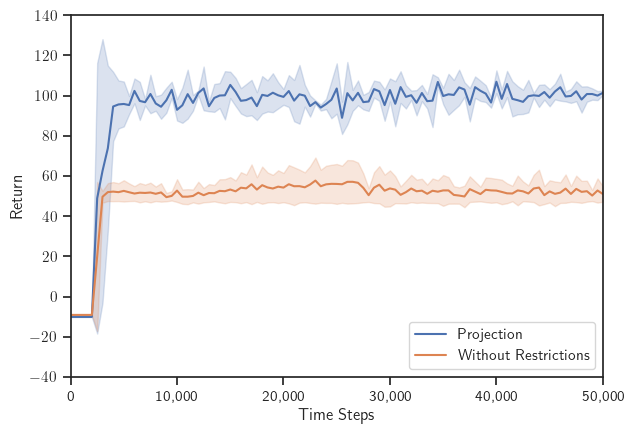

In [12]:
fig = plt.figure(figsize=(6.5, 4.5))
ax = sns.lineplot(data=results_dataframe, x='training_steps', y='return', hue='name', errorbar='sd')
ax.legend(title=None, loc='lower right', facecolor='white')
plt.ylim(-40.0, 140.0)
plt.xlim(0.0, 50000.0)
plt.ylabel('Return')
plt.xlabel('Time Steps')
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
fig.tight_layout()
plt.savefig('return-navigations.pdf', format='pdf', bbox_inches='tight', pad_inches = 0.0)

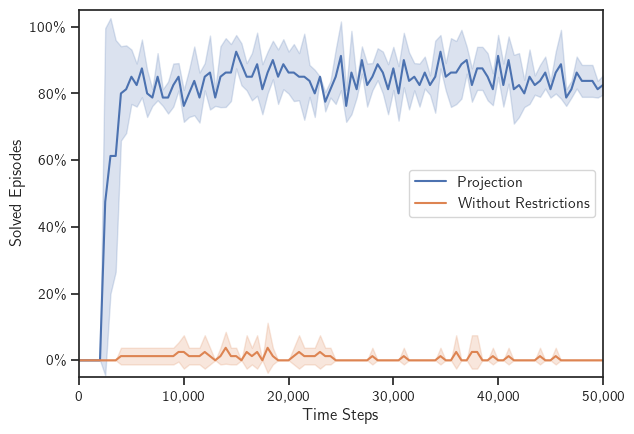

In [13]:
fig = plt.figure(figsize=(6.5, 4.5))
ax = sns.lineplot(data=results_dataframe, x='training_steps', y='solved', hue='name', errorbar='sd')
ax.legend(title=None, loc='center right', facecolor='white')
plt.ylim(-0.05, 1.05)
plt.xlim(0.0, 50000.0)
plt.ylabel('Solved Episodes')
plt.xlabel('Time Steps')
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
fig.tight_layout()
plt.savefig('solved-navigations.pdf', format='pdf', bbox_inches='tight', pad_inches = 0.0)

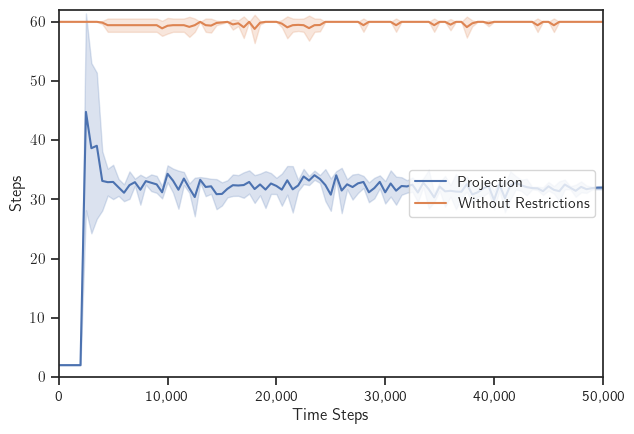

In [14]:
fig = plt.figure(figsize=(6.5, 4.5))
ax = sns.lineplot(data=results_dataframe, x='training_steps', y='steps', hue='name', errorbar='sd')
ax.legend(title=None, loc='center right', facecolor='white')
plt.ylim(0.0, 62.0)
plt.xlim(0.0, 50000.0)
plt.ylabel('Steps')
plt.xlabel('Time Steps')
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
fig.tight_layout()
plt.savefig('steps-navigations.pdf', format='pdf', bbox_inches='tight', pad_inches = 0.0)

###### Evaluation Runs

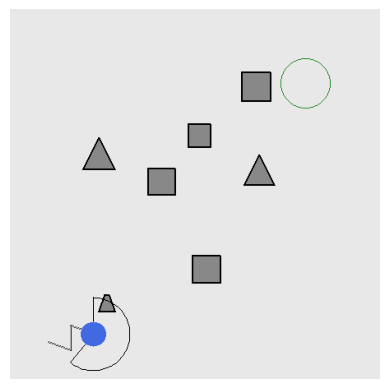

In [8]:
render(td3, env_config, restriction_violation_fns,
       seed=12)